In [45]:
import itertools
from pathlib import Path
import matplotlib

#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from scipy.stats import wasserstein_distance

import atd2020

font = {"family": "normal", "weight": "normal", "size": 14}
matplotlib.rc("font", **font)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
filename = Path("data/City1.parquet.brotli")
# filename = Path("data/City2_downsampled.parquet.brotli")

<IPython.core.display.Javascript object>

In [3]:
help(atd2020.utilities.read_data)

data = atd2020.utilities.read_data(filename)
data

Help on function read_data in module atd2020.utilities:

read_data(filepath)
    Reads parquet or csv into a dataframe with "Timestamp" as datetime.
    
    Parameters
    ----------
    filepath : str or Pathlib.Path
        Path to .csv or .parquet file containing "Timestamp" column.
    
    Returns
    -------
    pandas.DataFrame



,Timestamp,ID,TotalFlow,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed
0,2016-01-01 00:00:00,0,1058.0,2016,1,1,0,Friday,0.175793,0.167569,True,0.05,False
1,2016-01-01 01:00:00,0,853.0,2016,1,1,1,Friday,0.175793,0.167569,True,0.05,True
2,2016-01-01 02:00:00,0,631.0,2016,1,1,2,Friday,0.175793,0.167569,False,0.05,False
3,2016-01-01 03:00:00,0,502.0,2016,1,1,3,Friday,0.175793,0.167569,False,0.05,False
4,2016-01-01 04:00:00,0,353.0,2016,1,1,4,Friday,0.175793,0.167569,False,0.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770995,2017-12-31 19:00:00,782,469.0,2017,12,31,19,Sunday,0.604337,0.891310,False,0.10,False
8770996,2017-12-31 20:00:00,782,429.0,2017,12,31,20,Sunday,0.604337,0.891310,False,0.10,False
8770997,2017-12-31 21:00:00,782,303.0,2017,12,31,21,Sunday,0.604337,0.891310,False,0.10,False
8770998,2017-12-31 22:00:00,782,214.0,2017,12,31,22,Sunday,0.604337,0.891310,False,0.10,False


<IPython.core.display.Javascript object>

# Location of stations

In [7]:
stations = data[["ID", "Latitude", "Longitude"]]
stations = stations.drop_duplicates()
stations

,ID,Latitude,Longitude
0,0,0.175793,0.167569
744,2,0.174005,0.174833
1488,5,0.086816,0.179987
2232,6,0.097529,0.177976
2976,8,0.173294,0.176899
...,...,...,...
368280,776,0.224126,0.412723
369024,778,0.085535,0.234619
369768,779,0.171262,0.240763
370512,781,0.170981,0.238173


<IPython.core.display.Javascript object>

(0.25, 0.6)

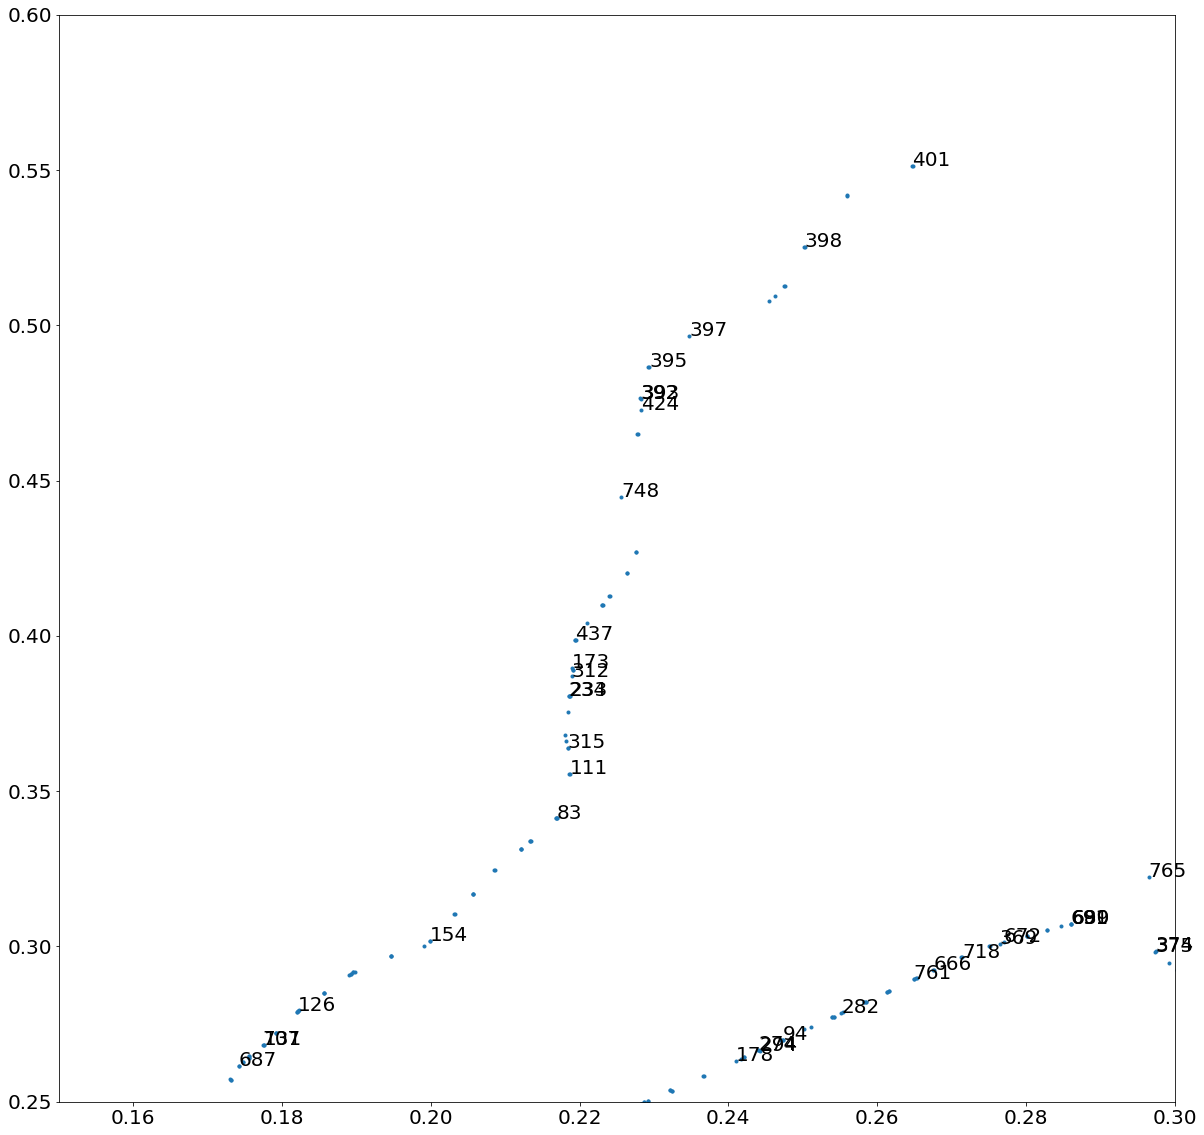

<IPython.core.display.Javascript object>

In [31]:
plt.figure(figsize=[20, 20])
plt.plot(stations["Latitude"], stations["Longitude"], ".")
for i in stations.index:
    if (
        stations["Fraction_Observed"][i] == 0.20
        and stations["Latitude"][i] > 0.15
        and stations["Latitude"][i] < 0.3
        and stations["Longitude"][i] > 0.25
        and stations["Longitude"][i] < 0.6
    ):
        plt.text(stations["Latitude"][i], stations["Longitude"][i], stations["ID"][i])
plt.xlim([0.15, 0.3])
plt.ylim([0.25, 0.6])

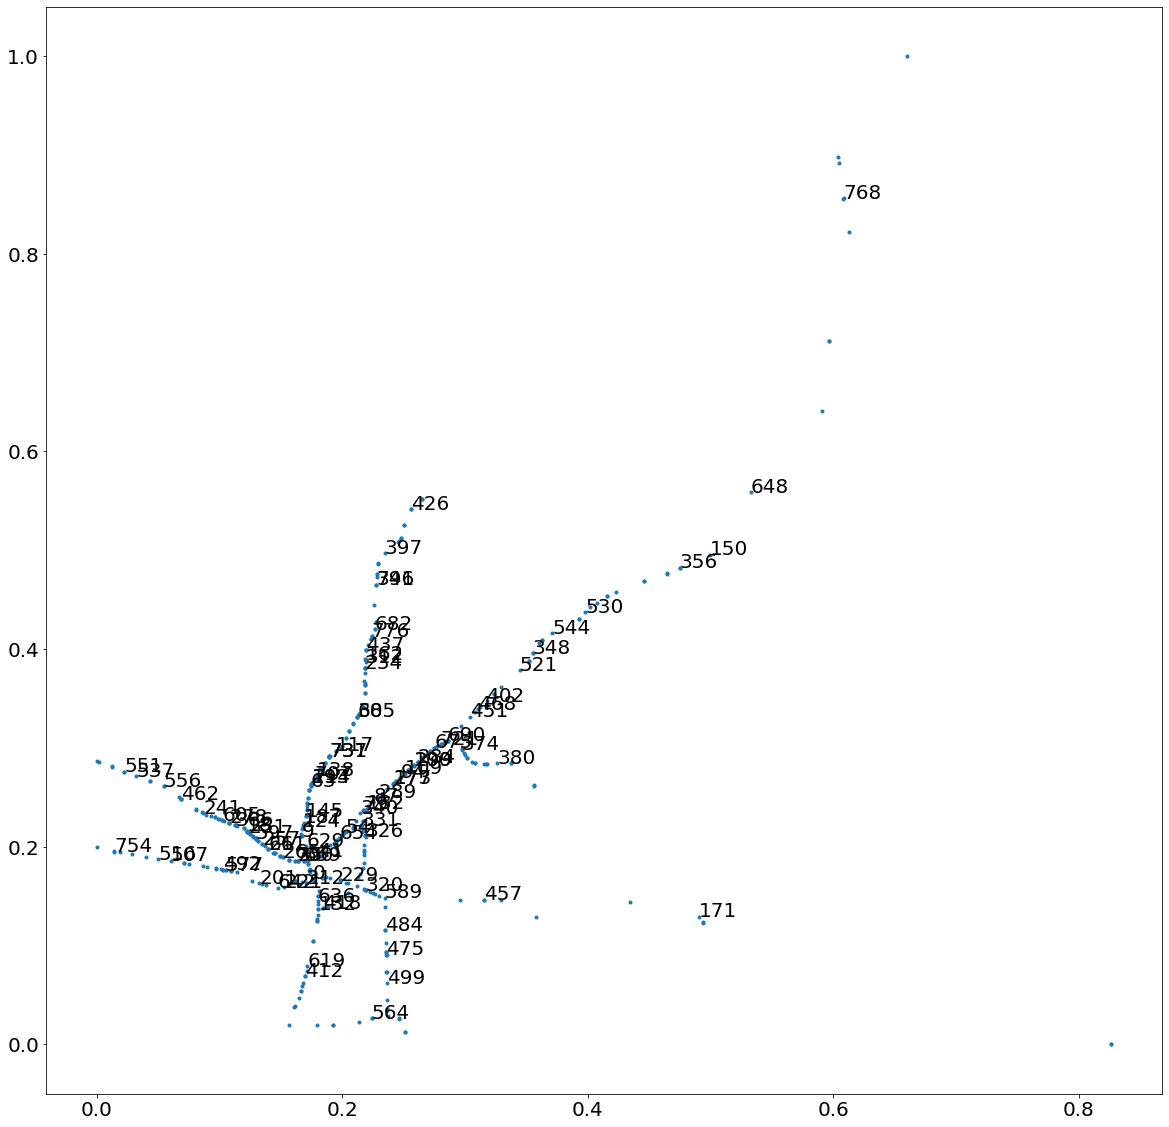

<IPython.core.display.Javascript object>

In [30]:
plt.figure(figsize=[20, 20])
plt.plot(stations["Latitude"], stations["Longitude"], ".")
for i in stations.index[::5]:
    plt.text(stations["Latitude"][i], stations["Longitude"][i], stations["ID"][i])

# How to identify which sensors are on the same road?

# Partial Data Rules

In [7]:
data[data["Observed"] == True]

,Timestamp,ID,TotalFlow,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed
1,2016-01-01 01:00:00,0,853.0,2016,1,1,1,Friday,0.175793,0.167569,True,0.05,True
12,2016-01-01 12:00:00,0,2731.0,2016,1,1,12,Friday,0.175793,0.167569,True,0.05,True
16,2016-01-01 16:00:00,0,2740.0,2016,1,1,16,Friday,0.175793,0.167569,False,0.05,True
82,2016-01-04 10:00:00,0,2567.0,2016,1,4,10,Monday,0.175793,0.167569,False,0.05,True
95,2016-01-04 23:00:00,0,790.0,2016,1,4,23,Monday,0.175793,0.167569,False,0.05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770907,2017-12-28 03:00:00,782,117.0,2017,12,28,3,Thursday,0.604337,0.891310,False,0.10,True
8770920,2017-12-28 16:00:00,782,1770.0,2017,12,28,16,Thursday,0.604337,0.891310,False,0.10,True
8770944,2017-12-29 16:00:00,782,1812.0,2017,12,29,16,Friday,0.604337,0.891310,False,0.10,True
8770955,2017-12-30 03:00:00,782,102.0,2017,12,30,3,Saturday,0.604337,0.891310,False,0.10,True


<IPython.core.display.Javascript object>

In [18]:
data[data["Observed"] == False]

,Timestamp,ID,TotalFlow,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed
0,2016-01-01 00:00:00,0,1058.0,2016,1,1,0,Friday,0.175793,0.167569,True,0.05,False
2,2016-01-01 02:00:00,0,631.0,2016,1,1,2,Friday,0.175793,0.167569,False,0.05,False
3,2016-01-01 03:00:00,0,502.0,2016,1,1,3,Friday,0.175793,0.167569,False,0.05,False
4,2016-01-01 04:00:00,0,353.0,2016,1,1,4,Friday,0.175793,0.167569,False,0.05,False
5,2016-01-01 05:00:00,0,400.0,2016,1,1,5,Friday,0.175793,0.167569,True,0.05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770995,2017-12-31 19:00:00,782,469.0,2017,12,31,19,Sunday,0.604337,0.891310,False,0.10,False
8770996,2017-12-31 20:00:00,782,429.0,2017,12,31,20,Sunday,0.604337,0.891310,False,0.10,False
8770997,2017-12-31 21:00:00,782,303.0,2017,12,31,21,Sunday,0.604337,0.891310,False,0.10,False
8770998,2017-12-31 22:00:00,782,214.0,2017,12,31,22,Sunday,0.604337,0.891310,False,0.10,False


<IPython.core.display.Javascript object>

In [21]:
set(data[data["Observed"] == True]["Fraction_Observed"])

{0.01, 0.02, 0.05, 0.1, 0.2}

<IPython.core.display.Javascript object>

In [40]:
print(
    len(set(data[data["Fraction_Observed"] == 0.01]["ID"])),
    len(data[data["Fraction_Observed"] == 0.01]),
    len(data[(data["Fraction_Observed"] == 0.01) & (data["Observed"] == True)]),
)
print(
    len(set(data[data["Fraction_Observed"] == 0.02]["ID"])),
    len(data[data["Fraction_Observed"] == 0.02]),
    len(data[(data["Fraction_Observed"] == 0.02) & (data["Observed"] == True)]),
)
print(
    len(set(data[data["Fraction_Observed"] == 0.05]["ID"])),
    len(data[data["Fraction_Observed"] == 0.05]),
    len(data[(data["Fraction_Observed"] == 0.05) & (data["Observed"] == True)]),
)
print(
    len(set(data[data["Fraction_Observed"] == 0.10]["ID"])),
    len(data[data["Fraction_Observed"] == 0.10]),
    len(data[(data["Fraction_Observed"] == 0.10) & (data["Observed"] == True)]),
)
print(
    len(set(data[data["Fraction_Observed"] == 0.20]["ID"])),
    len(data[data["Fraction_Observed"] == 0.20]),
    len(data[(data["Fraction_Observed"] == 0.20) & (data["Observed"] == True)]),
)

100 1754200 17600
100 1754200 35100
100 1754200 87800
100 1754200 175500
100 1754200 350900


<IPython.core.display.Javascript object>

In [29]:
for i in set(data[data["Fraction_Observed"] == 0.01]["ID"]):
    print(i in set(data[data["Fraction_Observed"] == 0.02]["ID"]))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


<IPython.core.display.Javascript object>

The whole dataset (500 IDs) are divided into 5 sets. each of them contain 100 of all stations. In each of the dataset, data were divided into two sets. 'Observed == True' and 'Observed == False'. The fraction of former is equal to 'Fraction_Observed'.

# Detrend

In [4]:
help(atd2020.detrend.detrend)

# Reset the index to observation number, since we previously set it to Timestamp when plotting in the above cells
data.reset_index(drop=True, inplace=True)

# If using full dataset, drop observations that were not "keep"
# if "Observed" in data.columns:
#    data = data.loc[data["Observed"]].copy()

# Detrend the data to make it stationary (constant mean and variance)
data_detrended = atd2020.detrend.detrend(data)
data_detrended

Help on function detrend in module atd2020.detrend:

detrend(df, inplace=False)
    Remove trend from TotalFlow.
    
    Parameters
    ----------
    df : pandas.DataFrame
        df containing columns=["ID", "Timestamp", TotalFlow"].
    
    inplace : bool, default=False
    
    Returns
    -------
    df : pandas.DataFrame or None
        Copy of df with detrended flow written to column "TotalFlow" and the original
        "TotalFlow" written to column "TotalFlow_original" or None if `inplace=True`.



,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow
0,2016-01-01 00:00:00,0,1058.0,2016,1,1,0,Friday,0.175793,0.167569,True,0.05,False,1070.495141
1,2016-01-01 01:00:00,0,853.0,2016,1,1,1,Friday,0.175793,0.167569,True,0.05,True,865.493717
2,2016-01-01 02:00:00,0,631.0,2016,1,1,2,Friday,0.175793,0.167569,False,0.05,False,643.492292
3,2016-01-01 03:00:00,0,502.0,2016,1,1,3,Friday,0.175793,0.167569,False,0.05,False,514.490868
4,2016-01-01 04:00:00,0,353.0,2016,1,1,4,Friday,0.175793,0.167569,False,0.05,False,365.489443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770995,2017-12-31 19:00:00,782,469.0,2017,12,31,19,Sunday,0.604337,0.891310,False,0.10,False,273.729321
8770996,2017-12-31 20:00:00,782,429.0,2017,12,31,20,Sunday,0.604337,0.891310,False,0.10,False,233.707048
8770997,2017-12-31 21:00:00,782,303.0,2017,12,31,21,Sunday,0.604337,0.891310,False,0.10,False,107.684775
8770998,2017-12-31 22:00:00,782,214.0,2017,12,31,22,Sunday,0.604337,0.891310,False,0.10,False,18.662502


<IPython.core.display.Javascript object>

In [8]:
data_detrended.to_csv("data.csv")

<IPython.core.display.Javascript object>

# Statistical Method

In [90]:
sensor_id = 73
weekday = "Monday"
hour = 0
group_name = (sensor_id, weekday, hour)
a = groups.get_group(group_name)
a[a["Observed"] == True]

,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow
719966,2016-02-01,73,563.0,2016,2,1,0,Monday,0.217818,0.196248,False,0.01,True,447.174895


<IPython.core.display.Javascript object>

In [79]:
example = set(data[data["Fraction_Observed"] == 0.01]["ID"])
example

{23,
 31,
 37,
 61,
 73,
 77,
 78,
 95,
 97,
 100,
 102,
 103,
 109,
 117,
 118,
 119,
 145,
 146,
 147,
 148,
 158,
 162,
 171,
 174,
 175,
 186,
 193,
 206,
 207,
 221,
 235,
 250,
 254,
 261,
 267,
 270,
 271,
 273,
 290,
 299,
 300,
 306,
 317,
 324,
 337,
 348,
 353,
 356,
 377,
 383,
 387,
 404,
 409,
 416,
 428,
 434,
 439,
 445,
 451,
 467,
 479,
 481,
 492,
 493,
 497,
 501,
 502,
 517,
 524,
 534,
 535,
 545,
 554,
 556,
 561,
 562,
 574,
 576,
 577,
 591,
 600,
 612,
 613,
 632,
 638,
 645,
 653,
 659,
 660,
 665,
 680,
 685,
 696,
 697,
 705,
 721,
 746,
 750,
 769,
 781}

<IPython.core.display.Javascript object>

In [46]:
example_01 = data[data["ID"] == 23]
example_01_observed = example_01[example_01["Observed"] == True]
example_02 = data[data["ID"] == 2]
example_02_observed = example_02[example_02["Observed"] == True]
example_05 = data[data["ID"] == 0]
example_05_observed = example_05[example_05["Observed"] == True]
example_10 = data[data["ID"] == 6]
example_10_observed = example_10[example_10["Observed"] == True]
example_20 = data[data["ID"] == 5]
example_20_observed = example_20[example_20["Observed"] == True]

<IPython.core.display.Javascript object>

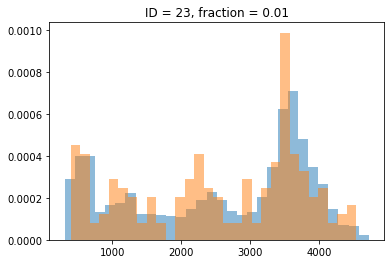

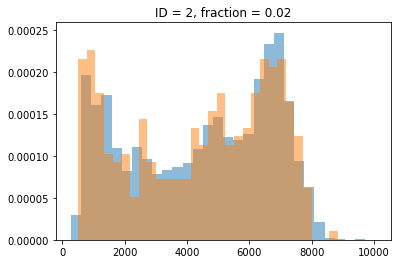

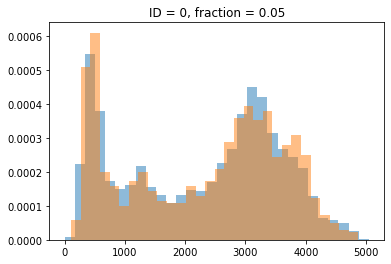

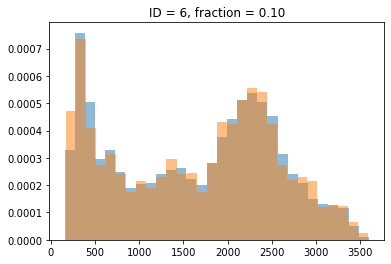

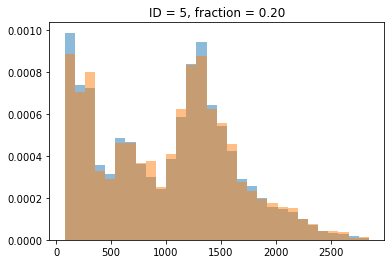

<IPython.core.display.Javascript object>

In [47]:
plt.hist(example_01["TotalFlow"], bins=30, density=True, alpha=0.5, label="All")
plt.hist(
    example_01_observed["TotalFlow"], bins=30, density=True, alpha=0.5, label="Observed"
)
plt.title("ID = 23, fraction = 0.01")
plt.show()

plt.hist(example_02["TotalFlow"], bins=30, density=True, alpha=0.5, label="All")
plt.hist(
    example_02_observed["TotalFlow"], bins=30, density=True, alpha=0.5, label="Observed"
)
plt.title("ID = 2, fraction = 0.02")
plt.show()

plt.hist(example_05["TotalFlow"], bins=30, density=True, alpha=0.5, label="All")
plt.hist(
    example_05_observed["TotalFlow"], bins=30, density=True, alpha=0.5, label="Observed"
)
plt.title("ID = 0, fraction = 0.05")
plt.show()

plt.hist(example_10["TotalFlow"], bins=30, density=True, alpha=0.5, label="All")
plt.hist(
    example_10_observed["TotalFlow"], bins=30, density=True, alpha=0.5, label="Observed"
)
plt.title("ID = 6, fraction = 0.10")
plt.show()

plt.hist(example_20["TotalFlow"], bins=30, density=True, alpha=0.5)
plt.hist(example_20_observed["TotalFlow"], bins=30, density=True, alpha=0.5)
plt.title("ID = 5, fraction = 0.20")
plt.show()

In [63]:
data = data_detrended

<IPython.core.display.Javascript object>

In [70]:
groups = data_detrended.groupby(["ID", "Weekday", "Hour"])
group_lst = list(groups.groups)
print(len(group_lst))
print(group_lst[:5])

84000
[(0, 'Friday', 0), (0, 'Friday', 1), (0, 'Friday', 2), (0, 'Friday', 3), (0, 'Friday', 4)]


<IPython.core.display.Javascript object>

In [71]:
sensor_id = 0
weekday = "Monday"
hour = 0
group_name = (sensor_id, weekday, hour)
groups.get_group(group_name)

,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow
72,2016-01-04,0,347.0,2016,1,4,0,Monday,0.175793,0.167569,False,0.05,False,359.392580
240,2016-01-11,0,386.0,2016,1,11,0,Monday,0.175793,0.167569,False,0.05,False,398.153269
408,2016-01-18,0,478.0,2016,1,18,0,Monday,0.175793,0.167569,False,0.05,False,489.913959
576,2016-01-25,0,437.0,2016,1,25,0,Monday,0.175793,0.167569,False,0.05,False,448.674649
744,2016-02-01,0,443.0,2016,2,1,0,Monday,0.175793,0.167569,False,0.05,False,454.435338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16702,2017-11-27,0,521.0,2017,11,27,0,Monday,0.175793,0.167569,False,0.05,False,509.700855
16870,2017-12-04,0,481.0,2017,12,4,0,Monday,0.175793,0.167569,False,0.05,False,469.461544
17038,2017-12-11,0,569.0,2017,12,11,0,Monday,0.175793,0.167569,False,0.05,False,557.222234
17206,2017-12-18,0,561.0,2017,12,18,0,Monday,0.175793,0.167569,False,0.05,False,548.982923


<IPython.core.display.Javascript object>

In [72]:
sensor_id = 768
weekday = "Monday"
hour = 0
group_name = (sensor_id, weekday, hour)
a = groups.get_group(group_name)
a[a["Observed"] == True]

,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow
8595652,2016-01-04,768,546.0,2016,1,4,0,Monday,0.60798,0.85552,True,0.2,True,672.925620
8595988,2016-01-18,768,90.0,2016,1,18,0,Monday,0.60798,0.85552,False,0.2,True,212.023555
8596324,2016-02-01,768,73.0,2016,2,1,0,Monday,0.60798,0.85552,False,0.2,True,190.121490
8596660,2016-02-15,768,136.0,2016,2,15,0,Monday,0.60798,0.85552,False,0.2,True,248.219425
8597331,2016-03-14,768,91.0,2016,3,14,0,Monday,0.60798,0.85552,False,0.2,True,193.415295
8598171,2016-04-18,768,146.0,2016,4,18,0,Monday,0.60798,0.85552,False,0.2,True,236.160133
8598675,2016-05-09,768,173.0,2016,5,9,0,Monday,0.60798,0.85552,False,0.2,True,255.807036
8599011,2016-05-23,768,154.0,2016,5,23,0,Monday,0.60798,0.85552,False,0.2,True,231.904971
8599347,2016-06-06,768,195.0,2016,6,6,0,Monday,0.60798,0.85552,False,0.2,True,268.002906
8599683,2016-06-20,768,211.0,2016,6,20,0,Monday,0.60798,0.85552,False,0.2,True,279.100841


<IPython.core.display.Javascript object>

(array([4., 5., 5., 6., 0., 1., 0., 1., 0., 1.]),
 array([ 88.31470365, 146.77579532, 205.23688698, 263.69797864,
        322.15907031, 380.62016197, 439.08125364, 497.5423453 ,
        556.00343696, 614.46452863, 672.92562029]),
 <BarContainer object of 10 artists>)

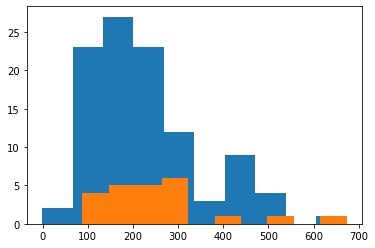

<IPython.core.display.Javascript object>

In [76]:
plt.hist(a["TotalFlow"])
plt.hist(a[a["Observed"] == True]["TotalFlow"])

Anormalies are too sparse to detect using naive method (in fact they are mostly not detected in lower values of observe fractions

In [67]:
len(a[a["Observed"] == True])

23

<IPython.core.display.Javascript object>

In [68]:
a

,Timestamp,ID,TotalFlow,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed
8595652,2016-01-04,768,546.0,2016,1,4,0,Monday,0.60798,0.85552,True,0.2,True
8595820,2016-01-11,768,92.0,2016,1,11,0,Monday,0.60798,0.85552,False,0.2,False
8595988,2016-01-18,768,90.0,2016,1,18,0,Monday,0.60798,0.85552,False,0.2,True
8596156,2016-01-25,768,132.0,2016,1,25,0,Monday,0.60798,0.85552,False,0.2,False
8596324,2016-02-01,768,73.0,2016,2,1,0,Monday,0.60798,0.85552,False,0.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8612282,2017-11-27,768,488.0,2017,11,27,0,Monday,0.60798,0.85552,False,0.2,False
8612450,2017-12-04,768,539.0,2017,12,4,0,Monday,0.60798,0.85552,False,0.2,False
8612618,2017-12-11,768,536.0,2017,12,11,0,Monday,0.60798,0.85552,False,0.2,False
8612786,2017-12-18,768,591.0,2017,12,18,0,Monday,0.60798,0.85552,False,0.2,False


<IPython.core.display.Javascript object>

In [93]:
stations = data[(data["Fraction_Observed"] == 0.01) & (data["Observed"] == True)][
    ["ID", "Latitude", "Longitude"]
]
stations = stations.drop_duplicates()
stations

,ID,Latitude,Longitude
228117,23,0.135034,0.202363
298216,31,0.151458,0.189687
386081,37,0.107909,0.224234
596445,61,0.216755,0.236709
719347,73,0.217818,0.196248
...,...,...,...
8157134,721,0.280090,0.303436
8420276,746,0.227735,0.465011
8455260,750,0.174820,0.262958
8613224,769,0.596121,0.711768


<IPython.core.display.Javascript object>

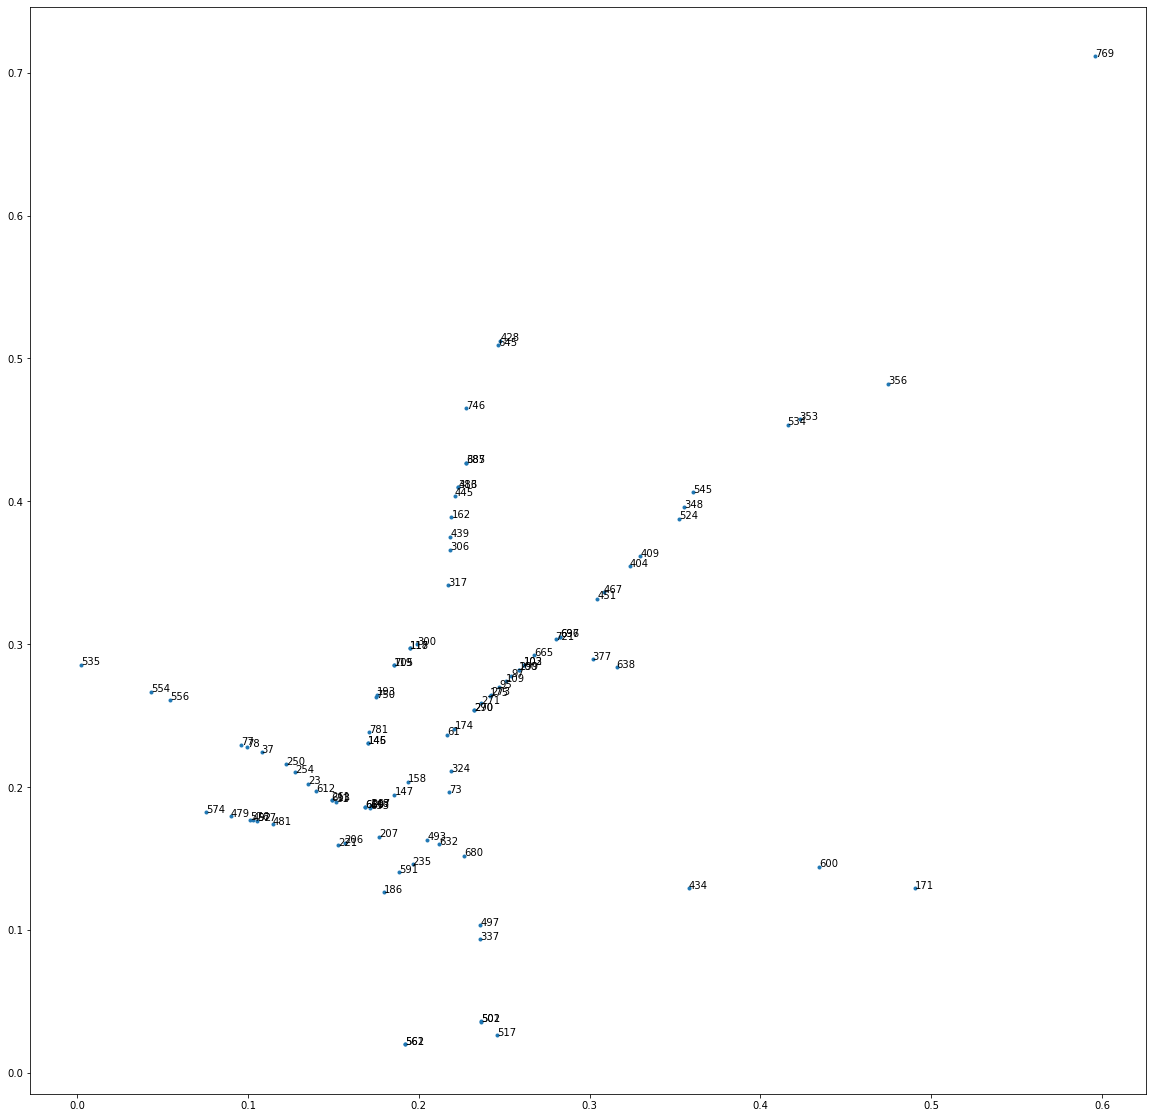

<IPython.core.display.Javascript object>

In [95]:
plt.figure(figsize=[20, 20])
plt.plot(stations["Latitude"], stations["Longitude"], ".")
for i in stations.index:
    plt.text(stations["Latitude"][i], stations["Longitude"][i], stations["ID"][i])

# Try a simple Neural Network with space and time

In [63]:
data_detrended

,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow,TimeInWeek,TotalFlowNormed,Probability
0,2016-01-01 00:00:00,0,1058.0,2016,1,1,0,Friday,0.175793,0.167569,True,0.05,False,1070.495141,0.714286,0.188799,1
1,2016-01-01 01:00:00,0,853.0,2016,1,1,1,Friday,0.175793,0.167569,True,0.05,True,865.493717,0.720238,0.178275,1
2,2016-01-01 02:00:00,0,631.0,2016,1,1,2,Friday,0.175793,0.167569,False,0.05,False,643.492292,0.726190,0.166877,0
3,2016-01-01 03:00:00,0,502.0,2016,1,1,3,Friday,0.175793,0.167569,False,0.05,False,514.490868,0.732143,0.160254,0
4,2016-01-01 04:00:00,0,353.0,2016,1,1,4,Friday,0.175793,0.167569,False,0.05,False,365.489443,0.738095,0.152605,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770995,2017-12-31 19:00:00,782,469.0,2017,12,31,19,Sunday,0.604337,0.891310,False,0.10,False,273.729321,0.113095,0.147894,0
8770996,2017-12-31 20:00:00,782,429.0,2017,12,31,20,Sunday,0.604337,0.891310,False,0.10,False,233.707048,0.119048,0.145839,0
8770997,2017-12-31 21:00:00,782,303.0,2017,12,31,21,Sunday,0.604337,0.891310,False,0.10,False,107.684775,0.125000,0.139369,0
8770998,2017-12-31 22:00:00,782,214.0,2017,12,31,22,Sunday,0.604337,0.891310,False,0.10,False,18.662502,0.130952,0.134799,0


<IPython.core.display.Javascript object>

## Preprocessing

In [7]:
day_of_the_week = {
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
}
time_in_week = (
    data_detrended.Weekday.map(day_of_the_week) * 24 + data_detrended.Hour
) / (7 * 24)
time_of_the_day = (data_detrended.Hour) / (24)
data_detrended["TimeInWeek"] = time_in_week
data_detrended["TimeOfTheDay"] = time_of_the_day

<IPython.core.display.Javascript object>

In [18]:
maxflow = max(data_detrended.TotalFlow)
minflow = min(data_detrended.TotalFlow)
print(maxflow, minflow)
data_detrended["TotalFlowNormed"] = (data_detrended["TotalFlow"] - minflow) / (
    maxflow - minflow
)

16871.1208308834 -2606.9532620966143


<IPython.core.display.Javascript object>

In [73]:
prob_map = {True: 1, False: 0}
data_detrended["Probability"] = data_detrended["Anomaly"].map(prob_map)

<IPython.core.display.Javascript object>

In [74]:
data = data_detrended[["TimeInWeek", "Latitude", "Longitude", "TotalFlowNormed", "Probability"]]
#data = data_detrended[
#    ["TimeInWeek", "Latitude", "Longitude", "TotalFlow", "Probability"]
#]
data

,TimeInWeek,Latitude,Longitude,TotalFlow,Probability
0,0.714286,0.175793,0.167569,1070.495141,1
1,0.720238,0.175793,0.167569,865.493717,1
2,0.726190,0.175793,0.167569,643.492292,0
3,0.732143,0.175793,0.167569,514.490868,0
4,0.738095,0.175793,0.167569,365.489443,0
...,...,...,...,...,...
8770995,0.113095,0.604337,0.891310,273.729321,0
8770996,0.119048,0.604337,0.891310,233.707048,0
8770997,0.125000,0.604337,0.891310,107.684775,0
8770998,0.130952,0.604337,0.891310,18.662502,0


<IPython.core.display.Javascript object>

In [75]:
data_x = data[["TimeInWeek", "Latitude", "Longitude", "TotalFlow"]]
data_y = data["Probability"]

<IPython.core.display.Javascript object>

## Define Model

In [76]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

<IPython.core.display.Javascript object>

In [77]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

<IPython.core.display.Javascript object>

In [33]:
layers = 3
neurons = 128
model = Sequential()
for i in range(layers):
    model.add(Dense(neurons, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[f1])

NameError: name 'Sequential' is not defined

<IPython.core.display.Javascript object>

## Start from full dataset

In [79]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [80]:
early_stopping_callback = EarlyStopping(monitor="f1", patience=5)

<IPython.core.display.Javascript object>

In [75]:
y_train

8260470    0
3936496    0
3057649    0
6775771    0
7768210    0
          ..
7204212    0
2234489    0
4304572    0
6550634    0
6423388    0
Name: Probability, Length: 7016800, dtype: int64

<IPython.core.display.Javascript object>

In [76]:
x_train

,TimeInWeek,Latitude,Longitude,TotalFlowNormed
8260470,0.357143,0.189569,0.291690,0.315798
3936496,0.910714,0.218584,0.355610,0.188791
3057649,0.511905,0.236568,0.258461,0.186801
6775771,0.857143,0.129414,0.208311,0.235912
7768210,0.904762,0.175511,0.264041,0.194783
...,...,...,...,...
7204212,0.107143,0.180314,0.144815,0.299140
2234489,0.333333,0.093408,0.230721,0.255823
4304572,0.089286,0.297458,0.298477,0.293425
6550634,0.172619,0.075554,0.182329,0.194178


<IPython.core.display.Javascript object>

In [81]:
model.fit(
    x_train,
    y_train,
    epochs=50,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
    callbacks=[early_stopping_callback],
)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



54819/54819 [==============================] - 52s 944us/step - loss: 0.0771 - f1: 7.9406e-06 - val_loss: 0.0683 - val_f1: 0.0000e+00
Epoch 2/50
40940/54819 [=====================>........] - ETA: 11s - loss: 0.0697 - f1: 1.1841e-05

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [45]:
a = model.predict(x_test)

<IPython.core.display.Javascript object>

In [59]:
tp = sum(np.round(a.squeeze()) * y_test)
pos = sum(y_test)
recall = tp / pos
pos_pre = sum(np.round(a.squeeze()))
precision = tp / pos_pre
f1 = 2 * (precision * recall) / (precision + recall)

<IPython.core.display.Javascript object>

In [62]:
recall

0.03625945655579928

<IPython.core.display.Javascript object>

In [43]:
a

array([[0.00766563],
       [0.00884521],
       [0.01562887],
       ...,
       [0.00370005],
       [0.00826272],
       [0.00694752]], dtype=float32)

<IPython.core.display.Javascript object>

## Try SVM

In [20]:
from sklearn import svm

<IPython.core.display.Javascript object>

In [19]:
data_detrended

,Timestamp,ID,TotalFlow_original,Year,Month,Day,Hour,Weekday,Latitude,Longitude,Anomaly,Fraction_Observed,Observed,TotalFlow,TimeInWeek,TotalFlowNormed
0,2016-01-01 00:00:00,0,1058.0,2016,1,1,0,Friday,0.175793,0.167569,True,0.05,False,1070.495141,0.714286,0.188799
1,2016-01-01 01:00:00,0,853.0,2016,1,1,1,Friday,0.175793,0.167569,True,0.05,True,865.493717,0.720238,0.178275
2,2016-01-01 02:00:00,0,631.0,2016,1,1,2,Friday,0.175793,0.167569,False,0.05,False,643.492292,0.726190,0.166877
3,2016-01-01 03:00:00,0,502.0,2016,1,1,3,Friday,0.175793,0.167569,False,0.05,False,514.490868,0.732143,0.160254
4,2016-01-01 04:00:00,0,353.0,2016,1,1,4,Friday,0.175793,0.167569,False,0.05,False,365.489443,0.738095,0.152605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8770995,2017-12-31 19:00:00,782,469.0,2017,12,31,19,Sunday,0.604337,0.891310,False,0.10,False,273.729321,0.113095,0.147894
8770996,2017-12-31 20:00:00,782,429.0,2017,12,31,20,Sunday,0.604337,0.891310,False,0.10,False,233.707048,0.119048,0.145839
8770997,2017-12-31 21:00:00,782,303.0,2017,12,31,21,Sunday,0.604337,0.891310,False,0.10,False,107.684775,0.125000,0.139369
8770998,2017-12-31 22:00:00,782,214.0,2017,12,31,22,Sunday,0.604337,0.891310,False,0.10,False,18.662502,0.130952,0.134799


<IPython.core.display.Javascript object>

In [107]:
# data[(data["Fraction_Observed"] == 0.01) & (data["Observed"] == True)])
data = data_detrended[
    (data_detrended["ID"] == 0)  # & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlowNormed", "Anomaly"]]
data_x = data[(data["Weekday"] != "Sunday") & (data["Weekday"] != "Saturday")][
    ["TimeOfTheDay", "TotalFlowNormed"]
]
data_y = data[(data["Weekday"] != "Sunday") & (data["Weekday"] != "Saturday")][
    "Anomaly"
]

<IPython.core.display.Javascript object>

In [112]:
data_x

,TimeOfTheDay,TotalFlowNormed
0,0.000000,0.188799
1,0.041667,0.178275
2,0.083333,0.166877
3,0.125000,0.160254
4,0.166667,0.152605
...,...,...
17489,0.791667,0.267251
17490,0.833333,0.243532
17491,0.875000,0.231878
17492,0.916667,0.214525


<IPython.core.display.Javascript object>

In [108]:
data_y

0         True
1         True
2        False
3        False
4        False
         ...  
17489    False
17490    False
17491    False
17492    False
17493    False
Name: Anomaly, Length: 12504, dtype: bool

<IPython.core.display.Javascript object>

In [97]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [110]:
clf = svm.SVC(kernel="rbf")
clf.fit(x_train, y_train)

SVC()

<IPython.core.display.Javascript object>

In [111]:
clf.predict([[0, 0.20]])

array([False])

<IPython.core.display.Javascript object>

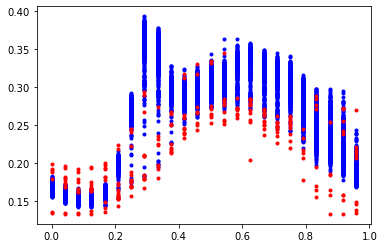

<IPython.core.display.Javascript object>

In [95]:
not_anomaly = data[
    (data["Anomaly"] == False)
    & (data["TimeInWeek"] > 1 / 7)
    & (data["TimeInWeek"] < 6 / 7)
][["TimeOfTheDay", "TotalFlowNormed"]]
anomaly = data[
    (data["Anomaly"] == True)
    & (data["TimeInWeek"] > 1 / 7)
    & (data["TimeInWeek"] < 6 / 7)
][["TimeOfTheDay", "TotalFlowNormed"]]
plt.plot(
    not_anomaly[["TimeOfTheDay"]], not_anomaly[["TotalFlowNormed"]], ".", color="blue"
)
plt.plot(anomaly[["TimeOfTheDay"]], anomaly[["TotalFlowNormed"]], ".", color="red")

,TimeInWeek,TimeOfTheDay,TotalFlowNormed,Anomaly
1,0.720238,0.041667,0.178275,True
12,0.785714,0.500000,0.274690,True
16,0.809524,0.666667,0.275152,False
82,0.202381,0.416667,0.266265,False
95,0.279762,0.958333,0.175033,False
...,...,...,...,...
17497,0.875000,0.125000,0.154149,False
17507,0.934524,0.541667,0.293074,False
17509,0.946429,0.625000,0.294306,False
17531,0.077381,0.541667,0.265348,False


<IPython.core.display.Javascript object>

In [82]:
data["TimeInWeek"]

1        0.720238
12       0.785714
16       0.809524
82       0.202381
95       0.279762
           ...   
17497    0.875000
17507    0.934524
17509    0.946429
17531    0.077381
17532    0.083333
Name: TimeInWeek, Length: 878, dtype: float64

<IPython.core.display.Javascript object>

## Try Isolation Forest

In [171]:
data = data_detrended[
    (data_detrended["ID"] == 768)  # & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlowNormed", "Anomaly"]]
data_x = data[(data["Weekday"] != "Sunday") & (data["Weekday"] != "Saturday")][
    ["TimeOfTheDay", "TotalFlowNormed"]
]

<IPython.core.display.Javascript object>

In [172]:
data_train = data[
    (data["Weekday"] != "Sunday")
    & (data["Weekday"] != "Saturday")
    & (data["Anomaly"] == False)
][["TimeOfTheDay", "TotalFlowNormed"]]

data_test = data[
    (data["Weekday"] != "Sunday")
    & (data["Weekday"] != "Saturday")
    & (data["Anomaly"] == True)
][["TimeOfTheDay", "TotalFlowNormed"]]

<IPython.core.display.Javascript object>

In [173]:
data_train

,TimeOfTheDay,TotalFlowNormed
8595580,0.000000,0.145750
8595581,0.041667,0.143490
8595582,0.083333,0.144516
8595583,0.125000,0.156940
8595584,0.166667,0.166078
...,...,...
8613069,0.791667,0.189174
8613070,0.833333,0.184142
8613071,0.875000,0.179623
8613072,0.916667,0.173718


<IPython.core.display.Javascript object>

In [174]:
data_test

,TimeOfTheDay,TotalFlowNormed
8595652,0.000000,0.168388
8595653,0.041667,0.167669
8595654,0.083333,0.166641
8595655,0.125000,0.168181
8595656,0.166667,0.168591
...,...,...
8612995,0.708333,0.228299
8612996,0.750000,0.205298
8612998,0.833333,0.185120
8613019,0.708333,0.204459


<IPython.core.display.Javascript object>

In [175]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(data_train)
clf.set_params(n_estimators=20)
clf.fit(X)

IsolationForest(n_estimators=20, warm_start=True)

<IPython.core.display.Javascript object>

In [176]:
Y_pre = clf.predict(data_test)

<IPython.core.display.Javascript object>

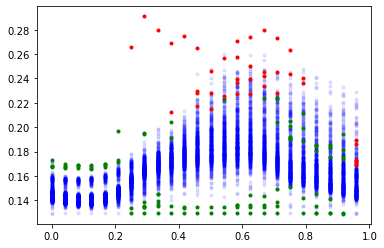

<IPython.core.display.Javascript object>

In [177]:
plt.plot(
    data_train["TimeOfTheDay"],
    data_train["TotalFlowNormed"],
    ".",
    color="blue",
    alpha=0.1,
)
plt.plot(
    data_test[Y_pre == 1]["TimeOfTheDay"],
    data_test[Y_pre == 1]["TotalFlowNormed"],
    ".",
    color="green",
)
plt.plot(
    data_test[Y_pre == -1]["TimeOfTheDay"],
    data_test[Y_pre == -1]["TotalFlowNormed"],
    ".",
    color="red",
)

In [181]:
data = data_detrended[
    (data_detrended["ID"] == 768)  # & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlow", "Anomaly"]]
data_train = data[data["Anomaly"] == False][["TimeInWeek", "TotalFlow"]]
data_test = data[data["Anomaly"] == True][["TimeInWeek", "TotalFlow"]]

<IPython.core.display.Javascript object>

In [182]:
data_train

,TimeInWeek,TotalFlow
8595580,0.714286,231.976063
8595581,0.720238,187.961473
8595582,0.726190,207.946884
8595583,0.732143,449.932294
8595584,0.738095,627.917705
...,...,...
8613117,0.113095,704.091189
8613118,0.119048,656.076600
8613119,0.125000,586.062010
8613120,0.130952,479.047421


<IPython.core.display.Javascript object>

In [183]:
data_test

,TimeInWeek,TotalFlow
8595652,0.142857,672.925620
8595653,0.148810,658.911031
8595654,0.154762,638.896441
8595655,0.160714,668.881852
8595656,0.166667,676.867262
...,...,...
8612995,0.386905,1839.871106
8612996,0.392857,1391.856516
8612998,0.404762,998.827337
8613019,0.529762,1375.520958


<IPython.core.display.Javascript object>

In [184]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(data_train)
clf.set_params(n_estimators=20)
clf.fit(X)
Y_pre = clf.predict(data_test)

<IPython.core.display.Javascript object>

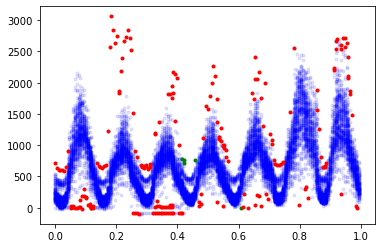

<IPython.core.display.Javascript object>

In [185]:
plt.plot(
    data_train["TimeInWeek"], data_train["TotalFlow"], ".", color="blue", alpha=0.1,
)
plt.plot(
    data_test[Y_pre == 1]["TimeInWeek"],
    data_test[Y_pre == 1]["TotalFlow"],
    ".",
    color="green",
)
plt.plot(
    data_test[Y_pre == -1]["TimeInWeek"],
    data_test[Y_pre == -1]["TotalFlow"],
    ".",
    color="red",
)

In [187]:
sum(Y_pre)

-192

<IPython.core.display.Javascript object>

## Decrease data_size 

In [5]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = np.sum(y_true * y_pred)
        possible_positives = np.sum(y_true)
        recall = true_positives / (possible_positives + 1e-12)
        return recall

    def precision(y_true, y_pred):
        true_positives = np.sum(y_true * y_pred)
        predicted_positives = np.sum(y_pred)
        precision = true_positives / (predicted_positives + 1e-12)
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + 1e-12))

<IPython.core.display.Javascript object>

In [8]:
data = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlow", "Anomaly"]]
data_train = data[data["Anomaly"] == False][["TimeInWeek", "TotalFlow"]]
data_val = data[data["Anomaly"] == True][["TimeInWeek", "TotalFlow"]]
data_test = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == False)
][["TimeInWeek", "TotalFlow"]]
Y_test = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == False)
]["Anomaly"]

<IPython.core.display.Javascript object>

In [189]:
data_train

,TimeInWeek,TotalFlow
8595580,0.714286,231.976063
8595583,0.732143,449.932294
8595587,0.755952,918.873936
8595593,0.791667,1625.786400
8595600,0.833333,960.684273
...,...,...
8613094,0.976190,928.426747
8613102,0.023810,362.310031
8613113,0.089286,1299.149547
8613114,0.095238,1321.134958


<IPython.core.display.Javascript object>

In [9]:
print(len(data_test), len(Y_test), len(data_val), len(data_val))

14033 14033 40 40


<IPython.core.display.Javascript object>

In [18]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=3)
clf.fit(data_train)
clf.fit(data_train)
Y_pre_val = clf.predict(data_val)
Y_pre_test = clf.predict(data_test)

<IPython.core.display.Javascript object>

4


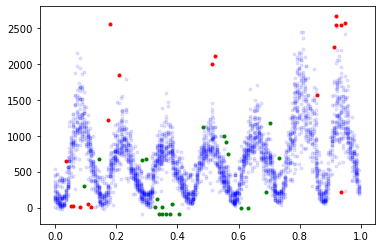

<IPython.core.display.Javascript object>

In [19]:
plt.plot(
    data_train["TimeInWeek"], data_train["TotalFlow"], ".", color="blue", alpha=0.1,
)
plt.plot(
    data_val[Y_pre_val == 1]["TimeInWeek"],
    data_val[Y_pre_val == 1]["TotalFlow"],
    ".",
    color="green",
)
plt.plot(
    data_val[Y_pre_val == -1]["TimeInWeek"],
    data_val[Y_pre_val == -1]["TotalFlow"],
    ".",
    color="red",
)
print(sum(Y_pre_val))

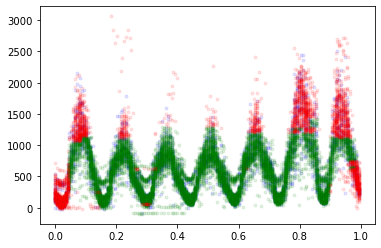

<IPython.core.display.Javascript object>

In [20]:
plt.plot(
    data_train["TimeInWeek"], data_train["TotalFlow"], ".", color="blue", alpha=0.1,
)
plt.plot(
    data_test[Y_pre_test == 1]["TimeInWeek"],
    data_test[Y_pre_test == 1]["TotalFlow"],
    ".",
    color="green",
    alpha=0.1,
)
plt.plot(
    data_test[Y_pre_test == -1]["TimeInWeek"],
    data_test[Y_pre_test == -1]["TotalFlow"],
    ".",
    color="red",
    alpha=0.1,
)

In [22]:
Y_pre_test = (Y_pre_test + 1) // 2

<IPython.core.display.Javascript object>

In [24]:
Y_test *= 1
f1(Y_test, Y_pre_test)

0.015052240127472707

<IPython.core.display.Javascript object>

# Try Random Forest

In [31]:
data = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlow", "Anomaly"]]
x_train = data[["TimeOfTheDay", "TotalFlow"]]
y_train = data["Anomaly"] * 1
x_test = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == False)
][["TimeInWeek", "TotalFlow"]]
Y_test = (
    data_detrended[
        (data_detrended["ID"] == 768) & (data_detrended["Observed"] == False)
    ]["Anomaly"]
    * 1
)

<IPython.core.display.Javascript object>

In [52]:
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier(max_depth=10, random_state=0)

<IPython.core.display.Javascript object>

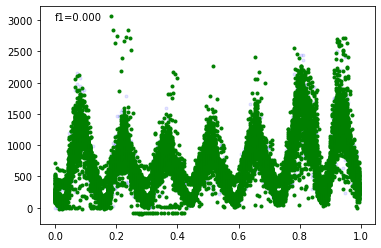

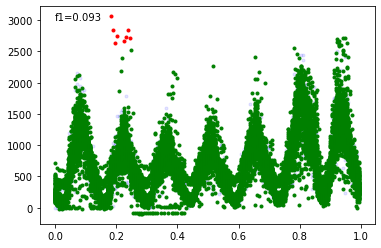

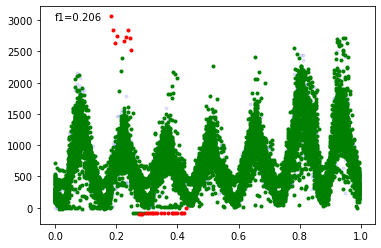

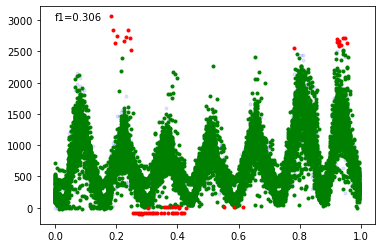

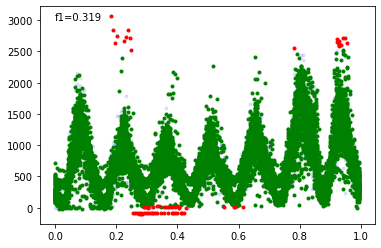

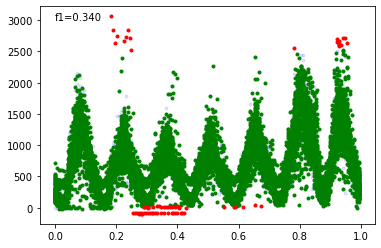

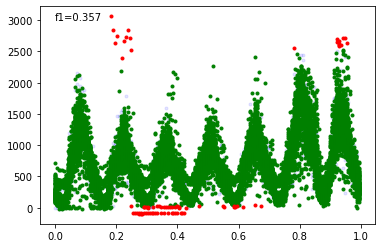

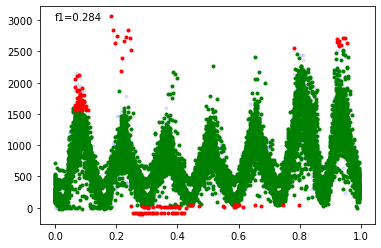

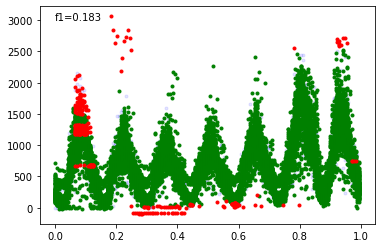

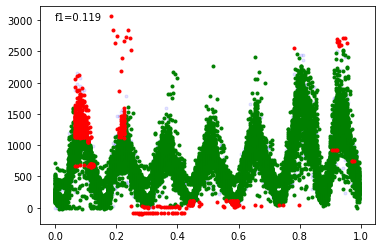

<IPython.core.display.Javascript object>

In [57]:
for i in range(1, 11):
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(x_train, y_train)
    Y_pre = clf.predict(x_test)
    plt.plot(
        data_train["TimeInWeek"], data_train["TotalFlow"], ".", color="blue", alpha=0.1,
    )
    plt.plot(
        x_test[Y_pre == 0]["TimeInWeek"],
        x_test[Y_pre == 0]["TotalFlow"],
        ".",
        color="green",
        alpha=1,
    )
    plt.plot(
        x_test[Y_pre == 1]["TimeInWeek"],
        x_test[Y_pre == 1]["TotalFlow"],
        ".",
        color="red",
        alpha=1,
    )
    f1_score = f1(Y_test, Y_pre)
    plt.text(0, 3000, "f1=%.3f" % f1_score)
    plt.show()

## By weekday

In [148]:
day_of_the_week = {
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
}
day_of_the_week_reverse = {day_of_the_week[key]: key for key in day_of_the_week}
data = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == True)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlow", "Anomaly"]]
data_test = data_detrended[
    (data_detrended["ID"] == 768) & (data_detrended["Observed"] == False)
][["Weekday", "TimeInWeek", "TimeOfTheDay", "TotalFlow", "Anomaly"]]

<IPython.core.display.Javascript object>

In [149]:
datax = [{"TimeOfTheDay": [], "TotalFlow": []} for i in range(7)]
datay = [{"Anomaly": []} for i in range(7)]
for i in range(len(data)):
    datax[day_of_the_week[data["Weekday"].iloc[i]]]["TimeOfTheDay"].append(
        data["TimeOfTheDay"].iloc[i]
    )
    datax[day_of_the_week[data["Weekday"].iloc[i]]]["TotalFlow"].append(
        data["TotalFlow"].iloc[i]
    )
    datay[day_of_the_week[data["Weekday"].iloc[i]]]["Anomaly"].append(
        data["Anomaly"].iloc[i]
    )
datax = [pd.DataFrame.from_dict(dic) for dic in datax]
datay = [np.ravel(pd.DataFrame.from_dict(dic) * 1) for dic in datay]

testx = testx = [{"TimeOfTheDay": [], "TotalFlow": []} for i in range(7)]
testy = [{"Anomaly": []} for i in range(7)]
for i in range(len(data_test)):
    testx[day_of_the_week[data_test["Weekday"].iloc[i]]]["TimeOfTheDay"].append(
        data_test["TimeOfTheDay"].iloc[i]
    )
    testx[day_of_the_week[data_test["Weekday"].iloc[i]]]["TotalFlow"].append(
        data_test["TotalFlow"].iloc[i]
    )
    testy[day_of_the_week[data_test["Weekday"].iloc[i]]]["Anomaly"].append(
        data_test["Anomaly"].iloc[i]
    )
testx = [pd.DataFrame.from_dict(dic) for dic in testx]
testy = [np.ravel(pd.DataFrame.from_dict(dic) * 1) for dic in testy]

<IPython.core.display.Javascript object>

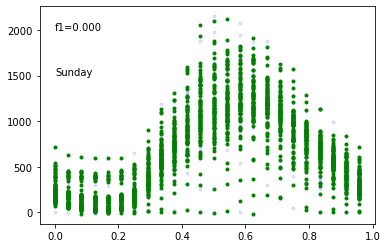

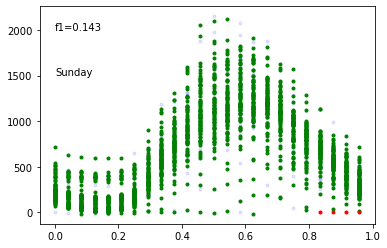

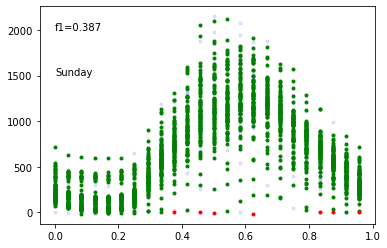

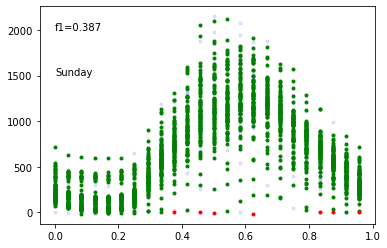

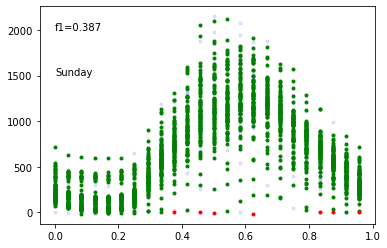

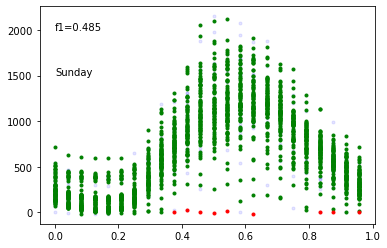

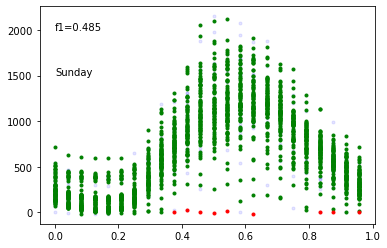

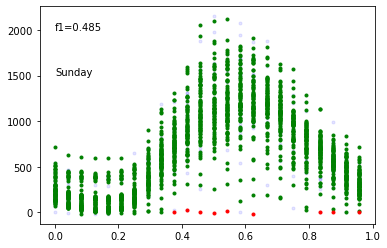

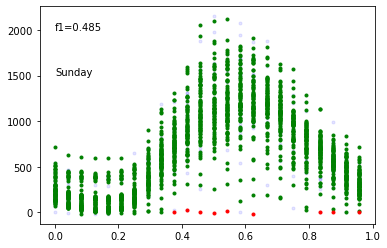

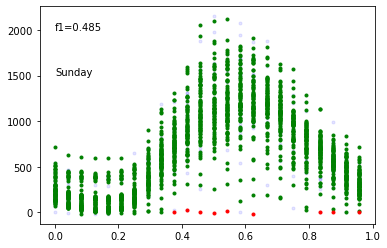

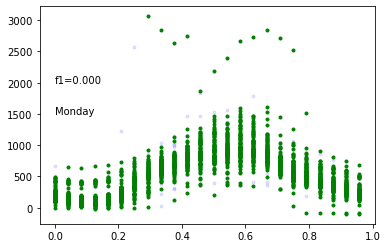

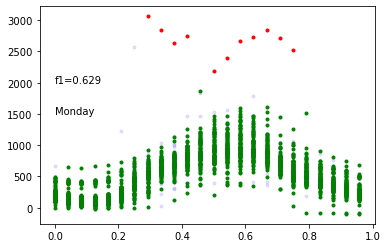

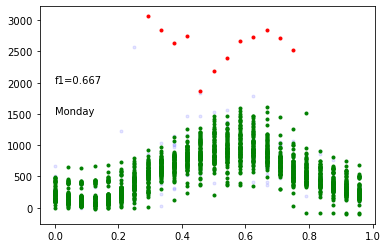

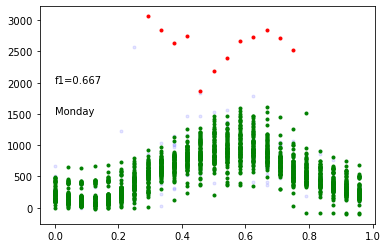

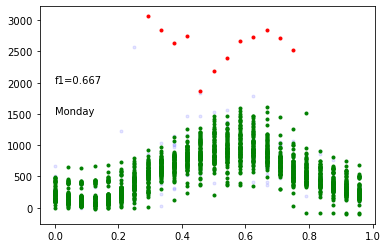

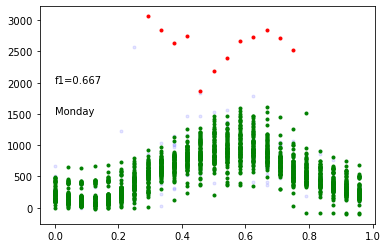

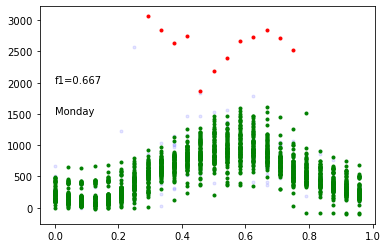

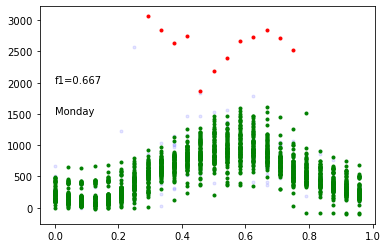

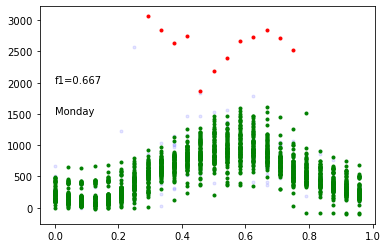

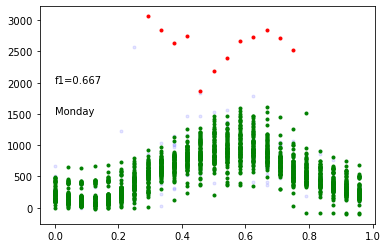

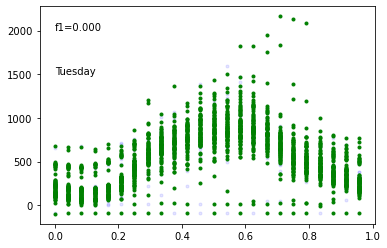

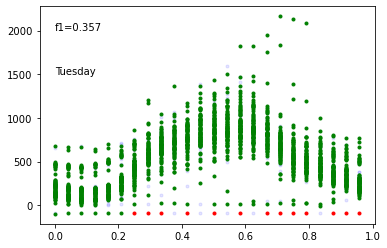

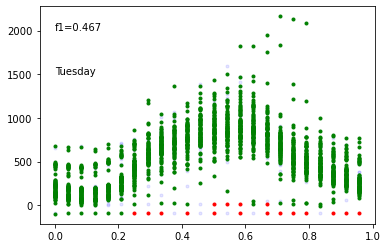

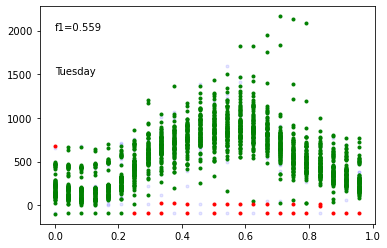

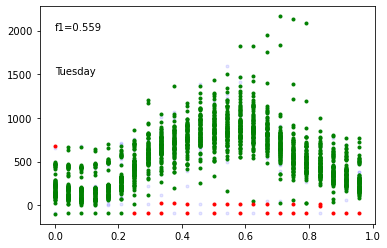

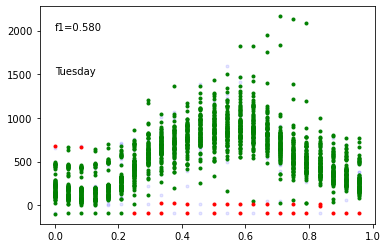

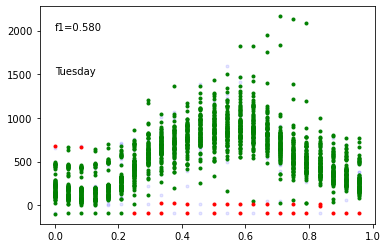

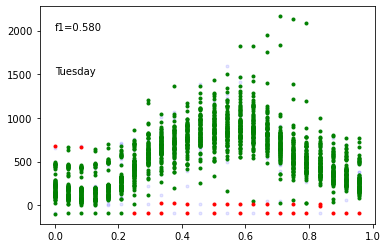

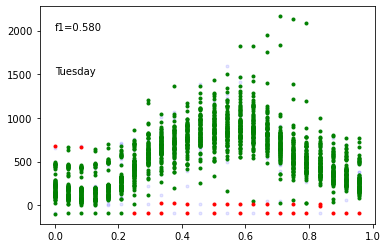

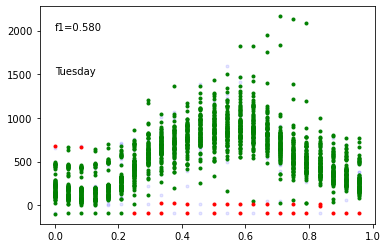

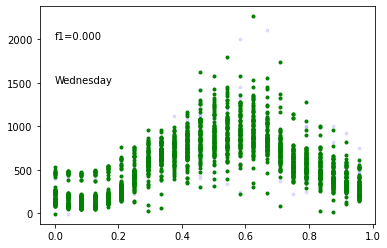

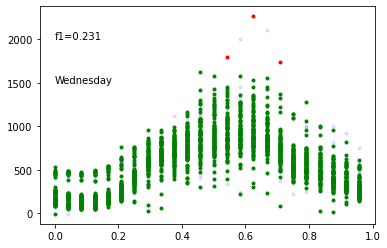

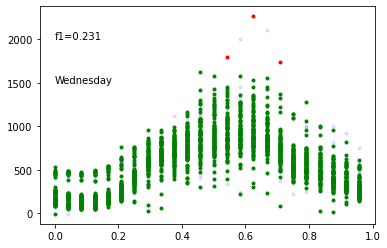

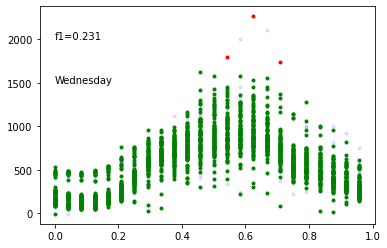

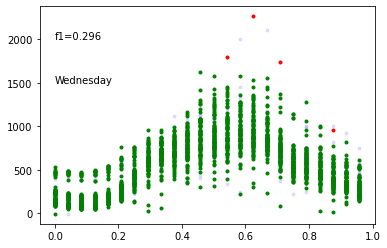

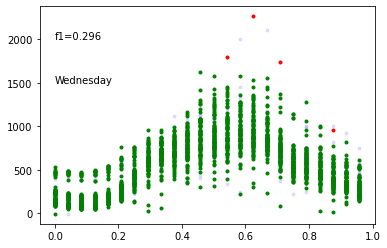

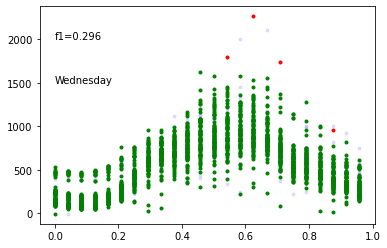

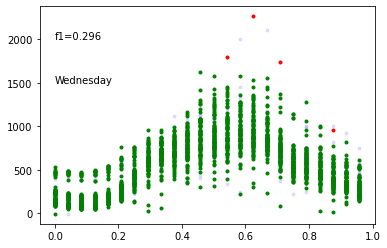

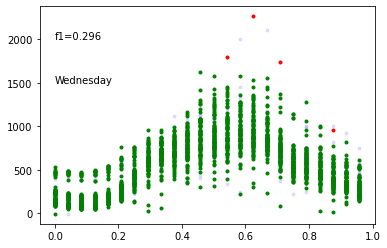

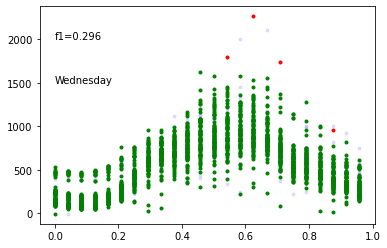

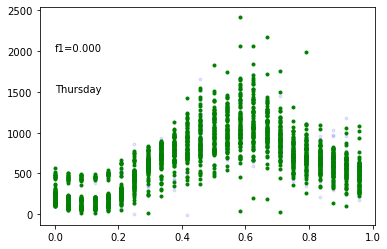

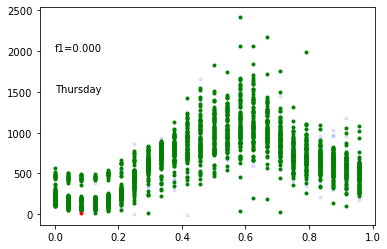

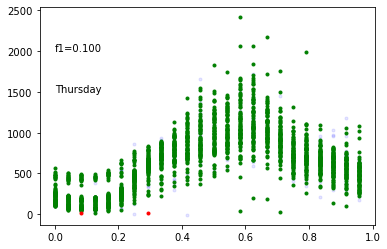

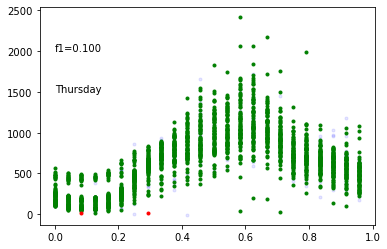

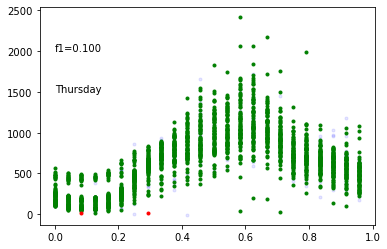

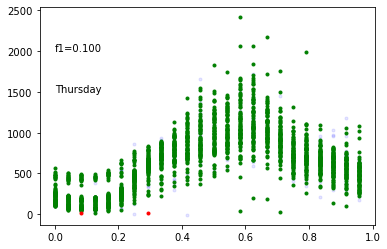

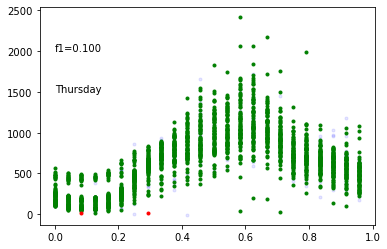

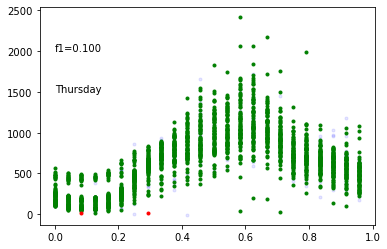

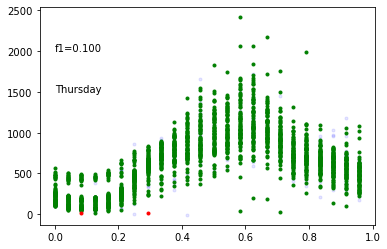

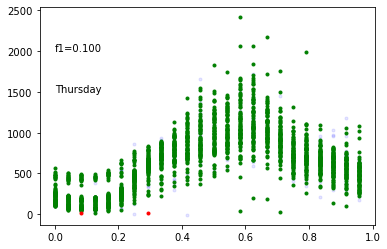

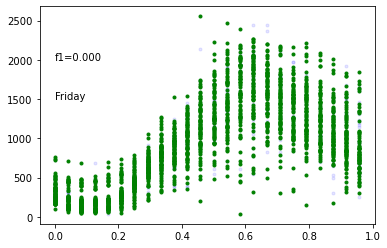

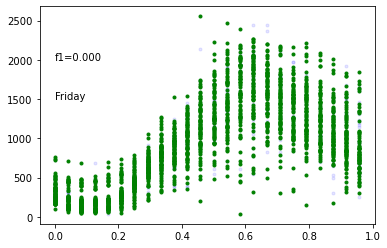

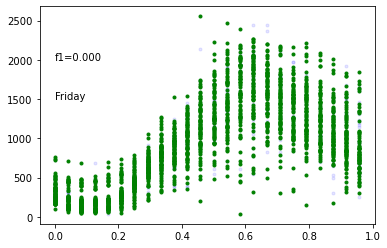

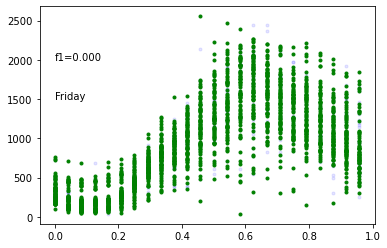

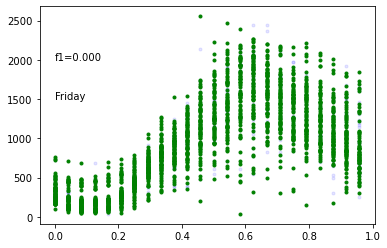

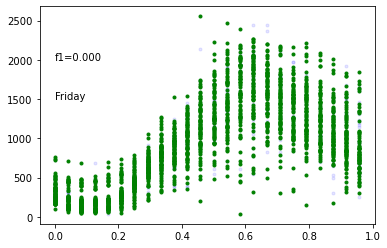

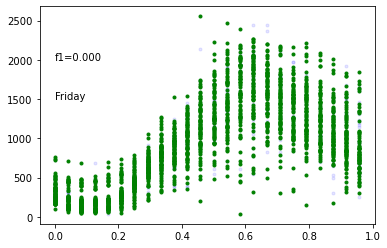

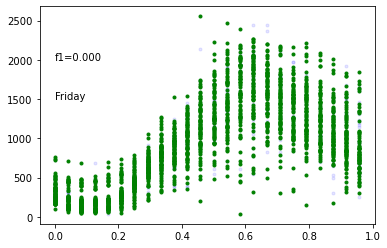

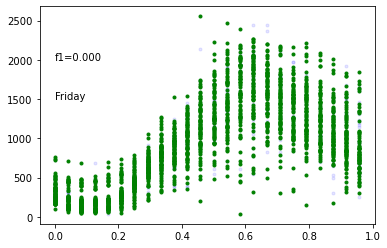

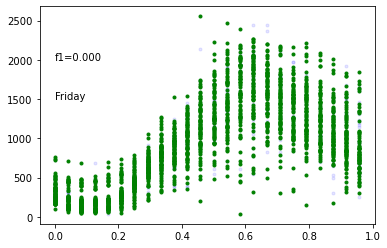

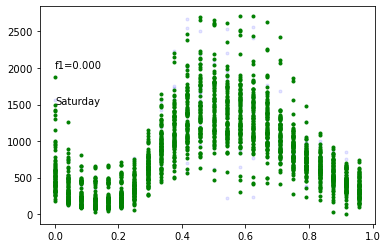

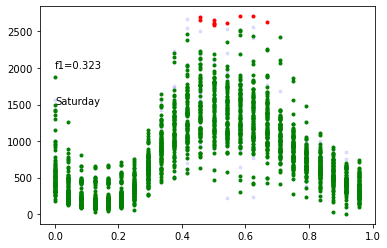

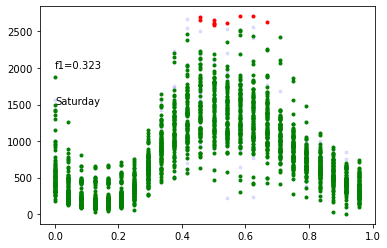

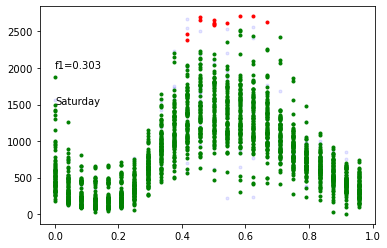

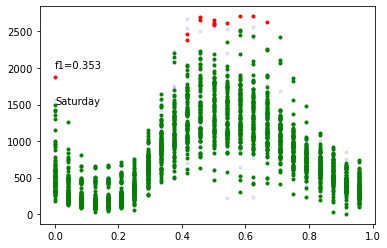

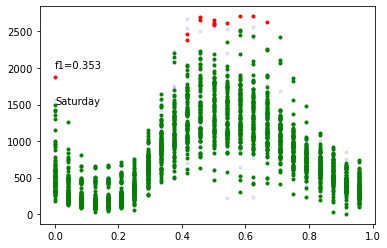

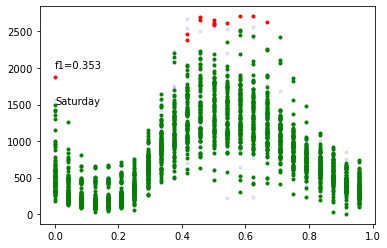

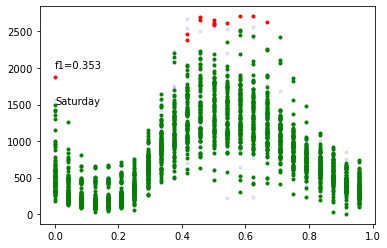

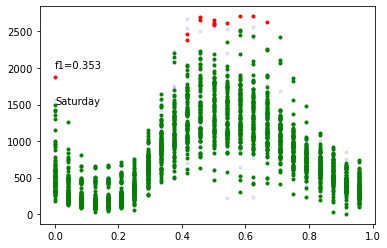

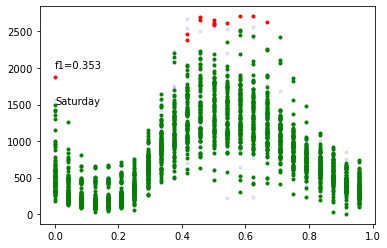

<IPython.core.display.Javascript object>

In [150]:
for j in range(7):
    day = day_of_the_week_reverse[j]
    for i in range(1, 11):
        clf = RandomForestClassifier(max_depth=i, random_state=0)
        clf.fit(datax[j], datay[j])
        Y_pre = clf.predict(testx[j])
        plt.plot(
            datax[j]["TimeOfTheDay"],
            datax[j]["TotalFlow"],
            ".",
            color="blue",
            alpha=0.1,
        )
        plt.plot(
            testx[j][Y_pre == 0]["TimeOfTheDay"],
            testx[j][Y_pre == 0]["TotalFlow"],
            ".",
            color="green",
            alpha=1,
        )
        plt.plot(
            testx[j][Y_pre == 1]["TimeOfTheDay"],
            testx[j][Y_pre == 1]["TotalFlow"],
            ".",
            color="red",
            alpha=1,
        )
        f1_score = f1(np.asarray(testy[j]).flatten(), Y_pre)
        plt.text(0, 2000, "f1=%.3f" % f1_score)
        plt.text(0, 1500, day)
        plt.show()

In [143]:
testy

[array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0])]

<IPython.core.display.Javascript object>

In [141]:
np.ravel(testy[0])

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

# Weekdays and Weekends variation

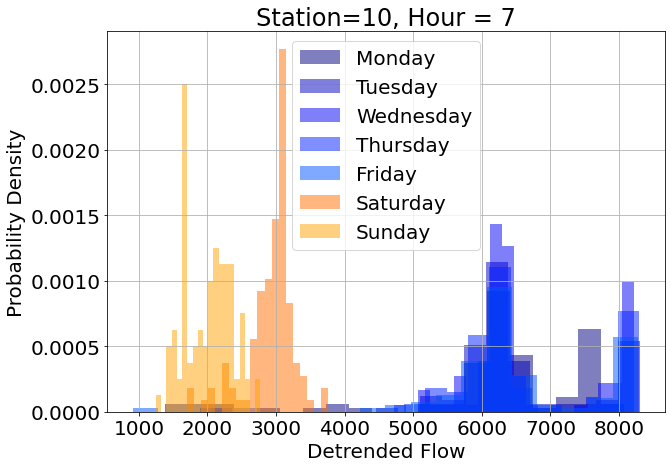

<IPython.core.display.Javascript object>

In [12]:
colors = colors = cm.jet(np.linspace(0, 1, 20))
df = data_detrended[data_detrended["ID"] == 10]
weekdays = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
plt.figure(figsize=[10, 7])
for i in range(len(weekdays)):
    weekday = weekdays[i]
    if i < 5:
        plt.hist(
            df[(df["Weekday"] == weekday) & (df["Hour"] == 7)]["TotalFlow"],
            density=True,
            label=weekday,
            alpha=0.5,
            bins=20,
            color=colors[i],
        )
    else:
        plt.hist(
            df[(df["Weekday"] == weekday) & (df["Hour"] == 7)]["TotalFlow"],
            density=True,
            label=weekday,
            alpha=0.5,
            bins=20,
            color=colors[20 - i],
        )
plt.xlabel("Detrended Flow")
plt.ylabel("Probability Density")
plt.title("Station=10, Hour = 7")
plt.legend(loc="best")
plt.grid()

In [17]:
df = data_detrended[(data_detrended["ID"] == 10) & (data_detrended["Hour"] == 7)]
histograms = []
for i in range(7):
    histograms.append(
        np.histogram(
            df[df["Weekday"] == weekdays[i]]["TotalFlow"], bins=20, density=True
        )
    )

<IPython.core.display.Javascript object>

In [33]:
average_was_distance = np.zeros([7, 7])
for station in range(500):
    for hour in range(24):
        print(station, hour, end = '\r')
        df = data_detrended[(data_detrended["ID"] == station) & (data_detrended["Hour"] == hour)]
        was_distances = np.zeros([7, 7])
        for i in range(7):
            for j in range(i, 7):
                val_i = [
                    (histograms[i][1][k + 1] + histograms[i][1][k]) / 2
                    for k in range(len(histograms[i][0]))
                ]
                val_j = [
                    (histograms[j][1][k + 1] + histograms[j][1][k]) / 2
                    for k in range(len(histograms[j][0]))
                ]
                wei_i, wei_j = histograms[i][0], histograms[j][0]
                was_distances[i][j] = was_distances[j][i] = wasserstein_distance(
                    val_i, val_j, wei_i, wei_j
                )
        average_was_distance += (was_distances/np.max(was_distances))

<IPython.core.display.Javascript object>

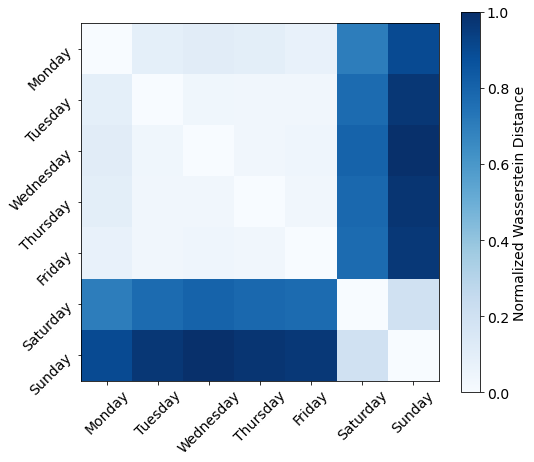

<IPython.core.display.Javascript object>

In [50]:
plt.figure(figsize=(8, 7))
plt.imshow(was_distances / np.max(was_distances), cmap="Blues")
plt.xticks([0, 1, 2, 3, 4, 5, 6], weekdays, rotation=45)
plt.yticks([0, 1, 2, 3, 4, 5, 6], weekdays, rotation=45)
cbar = plt.colorbar()
cbar.set_label("Normalized Wasserstein Distance")

<ipython-input-62-108aa78856e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HourInWeek"] = df.Weekday.map(day_of_the_week) * 24 + df["Hour"]
<ipython-input-62-108aa78856e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HourInWeek"] = df.Weekday.map(day_of_the_week) * 24 + df["Hour"]
<ipython-input-62-108aa78856e9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

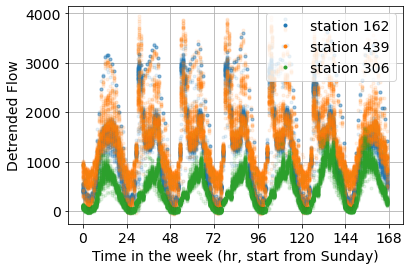

<IPython.core.display.Javascript object>

In [62]:
stations = [162, 439, 306]
day_of_the_week = {
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
}
for station in stations:
    df = data_detrended[(data_detrended["ID"] == station)]
    df["HourInWeek"] = df.Weekday.map(day_of_the_week) * 24 + df["Hour"]
    plt.plot(
        df["HourInWeek"],
        df["TotalFlow"],
        ".",
        alpha=0.1,
        label="station " + str(station),
    )
plt.grid()
plt.xticks([0, 24, 48, 72, 96, 120, 144, 168])
plt.xlabel("Time in the week (hr, start from Sunday)")
plt.ylabel("Detrended Flow")
leg = plt.legend(loc="best")

for lh in leg.legendHandles:
    lh._legmarker.set_alpha(1)

# Calculate Wasserstein Distance for different Priorities

In [73]:
def CreateStationPairs(df):
    stations = df[["ID", "Latitude", "Longitude"]].drop_duplicates()
    pairs = {}
    for i in stations.index:
        distance = float('Inf')
        for j in stations.index:
            if stations['ID'][i] != stations['ID'][j]:
                d = (stations["Latitude"][i] - stations["Latitude"][j]) ** 2 + (stations["Longitude"][i] - stations["Longitude"][j]) ** 2
                if d < distance:
                    distance = d
                    station = stations["ID"][j]
        pairs[stations["ID"][i]] = station
    return pairs

<IPython.core.display.Javascript object>

In [78]:
df = data_detrended[data_detrended["Fraction_Observed"] == 0.2]
pairs = CreateStationPairs(df)
stations = pairs.keys()

<IPython.core.display.Javascript object>

In [111]:
out_average = np.zeros(4)
out_all = []
for station in stations:
    df_station = df[df["ID"] == station]
    for hour in range(24):
        df_hour = df[df["Hour"] == hour]
        print(station, hour, end="\r")
        for i in range(7):
            was_weekday = 0
            was_hour_1 = 0
            weekday = weekdays[i]

            # Calculate was_weekday
            df_weekday = df_station[df_station["Weekday"] == weekday]
            df_1 = df_weekday[(df_weekday["Hour"] == hour)]["TotalFlow"]
            if i < 5:
                df_2 = df_station[
                    (df_station["Hour"] == hour)
                    & (df_station["Weekday"].isin(weekdays[:5]))
                ]["TotalFlow"]
            else:
                df_2 = df_station[
                    (df_station["Hour"] == hour)
                    & (df_station["Weekday"].isin(weekdays[5:]))
                ]["TotalFlow"]
            hist1 = np.histogram(df_1, bins=10, density=True)
            hist2 = np.histogram(df_2, bins=10, density=True)
            wei_1, wei_2 = hist1[0], hist2[0]
            val_1, val_2 = (
                [(hist1[1][k + 1] + hist1[1][k]) / 2 for k in range(len(hist1[0]))],
                [(hist2[1][k + 1] + hist2[1][k]) / 2 for k in range(len(hist2[0]))],
            )
            was_weekdays = wasserstein_distance(val_1, val_2, wei_1, wei_2)

            # Calculate was_hour_1
            adjacent_hours = [(hour + 1) % 24, hour, (hour - 1) % 24]
            df_2 = df_weekday[df_weekday["Hour"].isin(adjacent_hours)]["TotalFlow"]
            hist2 = np.histogram(df_2, bins=10, density=True)
            val_2 = [(hist2[1][k + 1] + hist2[1][k]) / 2 for k in range(len(hist2[0]))]
            was_hour_1 = wasserstein_distance(val_1, val_2, wei_1, wei_2)

            # Calculate was_hour_2
            adjacent_hours = [
                (hour + 2) % 24,
                (hour + 1) % 24,
                hour,
                (hour - 1) % 24,
                (hour - 2) % 24,
            ]
            df_2 = df_weekday[df_weekday["Hour"].isin(adjacent_hours)]["TotalFlow"]
            hist2 = np.histogram(df_2, bins=10, density=True)
            val_2 = [(hist2[1][k + 1] + hist2[1][k]) / 2 for k in range(len(hist2[0]))]
            was_hour_2 = wasserstein_distance(val_1, val_2, wei_1, wei_2)

            # Calculate was_station
            df_pair = df[df["ID"] == pairs[station]]
            df_2 = df_pair[(df_pair["Hour"] == hour) & (df_pair["Weekday"] == weekday)][
                "TotalFlow"
            ]
            hist2 = np.histogram(df_2, bins=10, density=True)
            val_2 = [(hist2[1][k + 1] + hist2[1][k]) / 2 for k in range(len(hist2[0]))]
            was_station = wasserstein_distance(val_1, val_2, wei_1, wei_2)

            out_append = np.asarray([was_weekdays, was_hour_1, was_hour_2, was_station])
            out_append /= np.mean(df_1)
            out_average += out_append
            out_all.append(out_append)

<IPython.core.display.Javascript object>

In [146]:
out_median = []
for i in range(4):
    out_median.append(np.percentile(out_all[:, i], 50))

<IPython.core.display.Javascript object>

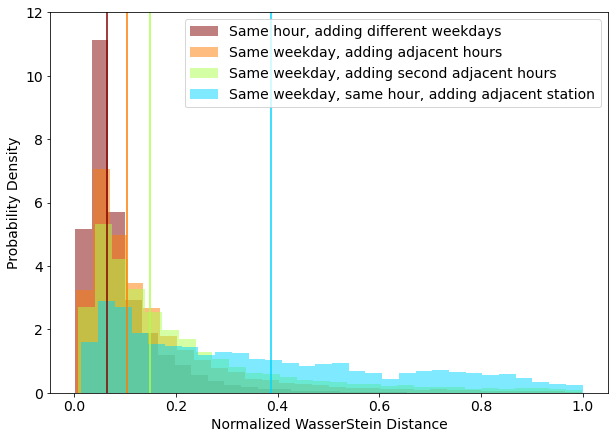

<IPython.core.display.Javascript object>

In [159]:
plt.figure(figsize=[10, 7])
labels = [
    "Same hour, adding different weekdays",
    "Same weekday, adding adjacent hours",
    "Same weekday, adding second adjacent hours",
    "Same weekday, same hour, adding adjacent station",
]
colors = colors = cm.jet(np.linspace(0, 1, 10))[::-1]
out_all = np.asarray(out_all)
for i in range(4):
    plt.hist(
        out_all[:, i][out_all[:, i] < 1.0],
        bins=30,
        density=True,
        alpha=0.5,
        color=colors[i * 2],
        label=labels[i],
    )
    plt.plot([out_median[i], out_median[i]], [0, 12], color=colors[i * 2])
plt.ylim([0, 12])
plt.xlabel("Normalized WasserStein Distance")
plt.ylabel("Probability Density")
plt.legend(loc="best")

(0.0, 0.8)

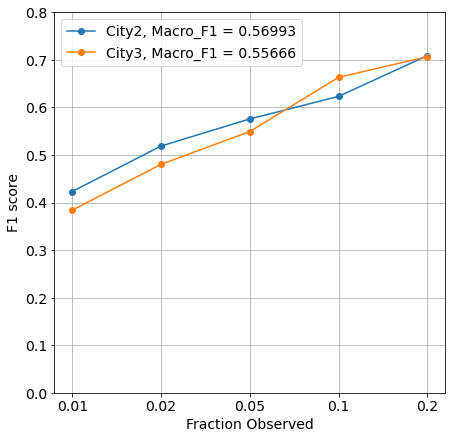

<IPython.core.display.Javascript object>

In [158]:
plt.figure(figsize=[7, 7])
fractions = [0.01, 0.02, 0.05, 0.10, 0.20]
eval_city2 = [0.423154, 0.518744, 0.575726, 0.623163, 0.708844]
eval_city3 = [0.383929, 0.480278, 0.549284, 0.663178, 0.706630]
plt.plot(eval_city2, "-o", label="City2, Macro_F1 = %.5f" % (np.mean(eval_city2)))
plt.plot(eval_city3, "-o", label="City3, Macro_F1 = %.5f" % (np.mean(eval_city3)))
plt.xticks(range(5), fractions)
plt.grid()
plt.legend(loc="best")
plt.xlabel("Fraction Observed")
plt.ylabel("F1 score")
plt.ylim([0, 0.8])

In [126]:
np.percentile(max(out_all[:, 3]), 0.9)

386.8578024814969

<IPython.core.display.Javascript object>

(array([9.162e+03, 2.948e+03, 1.000e+03, 3.420e+02, 1.260e+02, 6.100e+01,
        2.600e+01, 8.000e+00, 4.000e+00, 4.000e+00]),
 array([0.00228821, 0.08084089, 0.15939357, 0.23794626, 0.31649894,
        0.39505162, 0.47360431, 0.55215699, 0.63070967, 0.70926236,
        0.78781504]),
 <BarContainer object of 10 artists>)

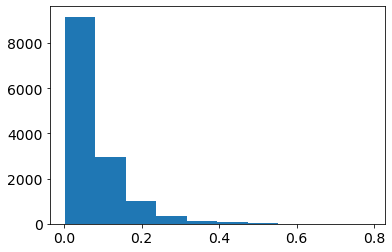

<IPython.core.display.Javascript object>

In [135]:
plt.hist(out_all[:, 0][out_all[:, 3] < 1])